In [ ]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [7]:
%ls ../data/

profit.csv*


In [ ]:
# leo el csv con pandas
df = pd.read_csv('../data/profit.csv', sep=',')

# me quedo solo con el año y el mes YYYY-MM de la columna Fecha Venta
df['Fecha Venta'] = pd.to_datetime(df['Fecha Venta'])
df['Anio-Mes'] = df['Fecha Venta'].dt.to_period('M')
# agrupo por Anio-Mes y calculo la suma de Profit
df_grouped = df.groupby('Anio-Mes')['Ganancia/Perdida ($)'].sum().reset_index()

df_grouped

,Anio-Mes,Ganancia/Perdida ($)
0,2024-06,30837.65
1,2024-08,-7697.27
2,2024-11,142881.56
3,2024-12,192692.16
4,2025-01,221333.86
5,2025-02,85555.65
6,2025-03,7577.32
7,2025-04,-263803.17
8,2025-05,-180215.81
9,2025-06,69781.32


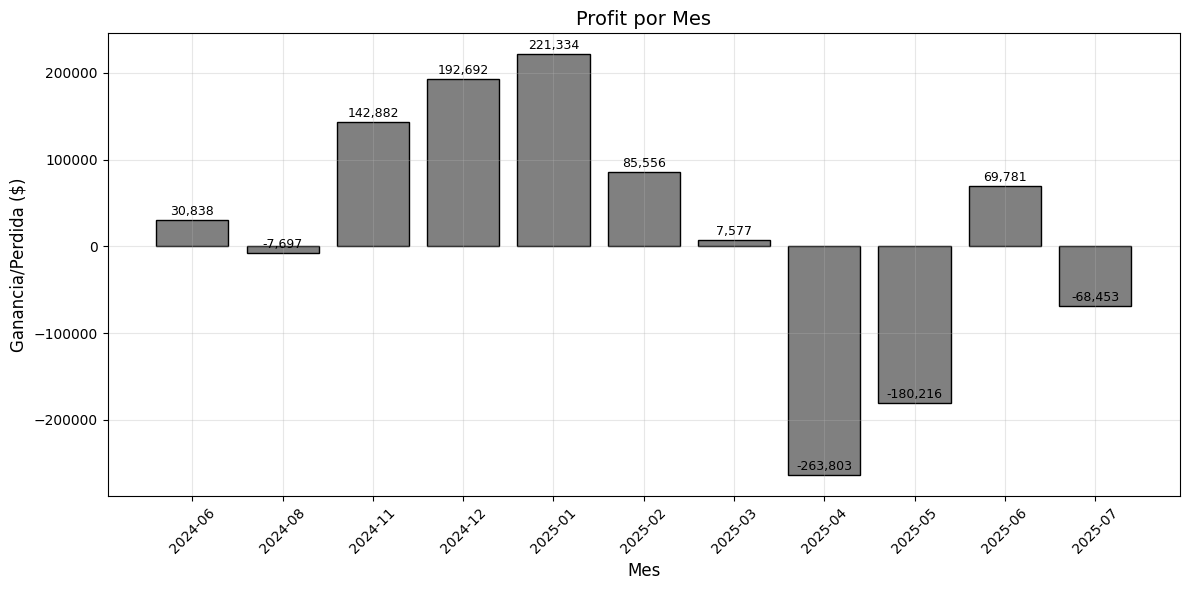

In [ ]:


# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot
bars = ax.bar(range(len(df_grouped)), df_grouped['Ganancia/Perdida ($)'], 
              color='gray', edgecolor='black', width=0.8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, df_grouped['Ganancia/Perdida ($)'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(df_grouped['Ganancia/Perdida ($)']) * 0.01),
            f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_title('Profit por Mes', fontsize=14)
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Ganancia/Perdida ($)', fontsize=12)
ax.set_xticks(range(len(df_grouped)))
ax.set_xticklabels(df_grouped['Anio-Mes'], rotation=45, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()